Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [3]:
!pip install spacy -q 
!python3 -m spacy download en_core_web_sm
!pip install eli5 -q

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 12.0 MB 264 kB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011737 sha256=dd4623aac7f81fbd7279fc7dc25c8f4ca3bf548d4d7d26162d0efbda48078448
  Stored in directory: /tmp/pip-ephem-wheel-cache-hepleftt/wheels/51/19/da/a3885266a3c241aff0ad2eb674ae058fd34a4870fef1c0a5a0
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [4]:
import os

#import warnings
#warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from scipy.sparse import hstack

#import nltk
#nltk.download('stopwords')
#from nltk.corpus import stopwords

import string

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

import catboost
from catboost import Pool, CatBoostClassifier

from tqdm import tqdm, tqdm_notebook, notebook

from joblib import dump, load

import eli5

import matplotlib.pyplot as plt
import seaborn as sns

#import torch
#from transformers import BertTokenizer, BertModel, BertForMaskedLM

import gc

DATA_PREPARED_FILE = "toxic_comments_ready"
GRID_FILE = "grid_nlp"
MODEL_FILE = "toxic_comments_model"


PATH = '/datasets/'
SEED = 21

In [5]:
data = pd.read_csv(os.path.join(PATH, 'toxic_comments.csv'))

In [6]:
data.sample(5, random_state=SEED)

,text,toxic
45925,Photograph \n\nThere's nothing wrong with your...,0
1242,"""\nre this, it looks like Ultrabias/DY71. ^_^ """,0
105698,No. There is no imagery or significance easil...,0
125591,The title of this article shouldn't have a quo...,0
13235,This IP address has also vandalized Lancaster ...,0


In [7]:
max_len = data['text'].str.len().max()
max_len

5000

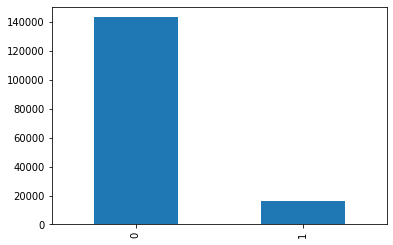

In [8]:
data['toxic'].value_counts().plot(kind='bar')

## Анализ

У нас неочищенные английские тексты.

Так же есть дисбаланс классов.

Попробуем провести немного EDA добавив мета признаки:
1. Количесво слов
1. Количество уникальных слов
1. Количетво стоп слов
1. Количетво ссылок
1. Средняя длина слова
1. Количество символов
1. Количетсо знаков препинания

In [9]:
def add_meta_feat(df, stopwords):
    
    # word_count
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

    # unique_word_count
    df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))
    
    # stop_word_count
    df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

    # url_count
    df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
  
    # mean_word_length
    df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    
    # char_count
    df['char_count'] = df['text'].apply(lambda x: len(str(x)))
    
    # punctuation_count
    df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
    return df

In [10]:
%%time
data = add_meta_feat(data, STOP_WORDS)

CPU times: user 17.7 s, sys: 0 ns, total: 17.7 s
Wall time: 18 s


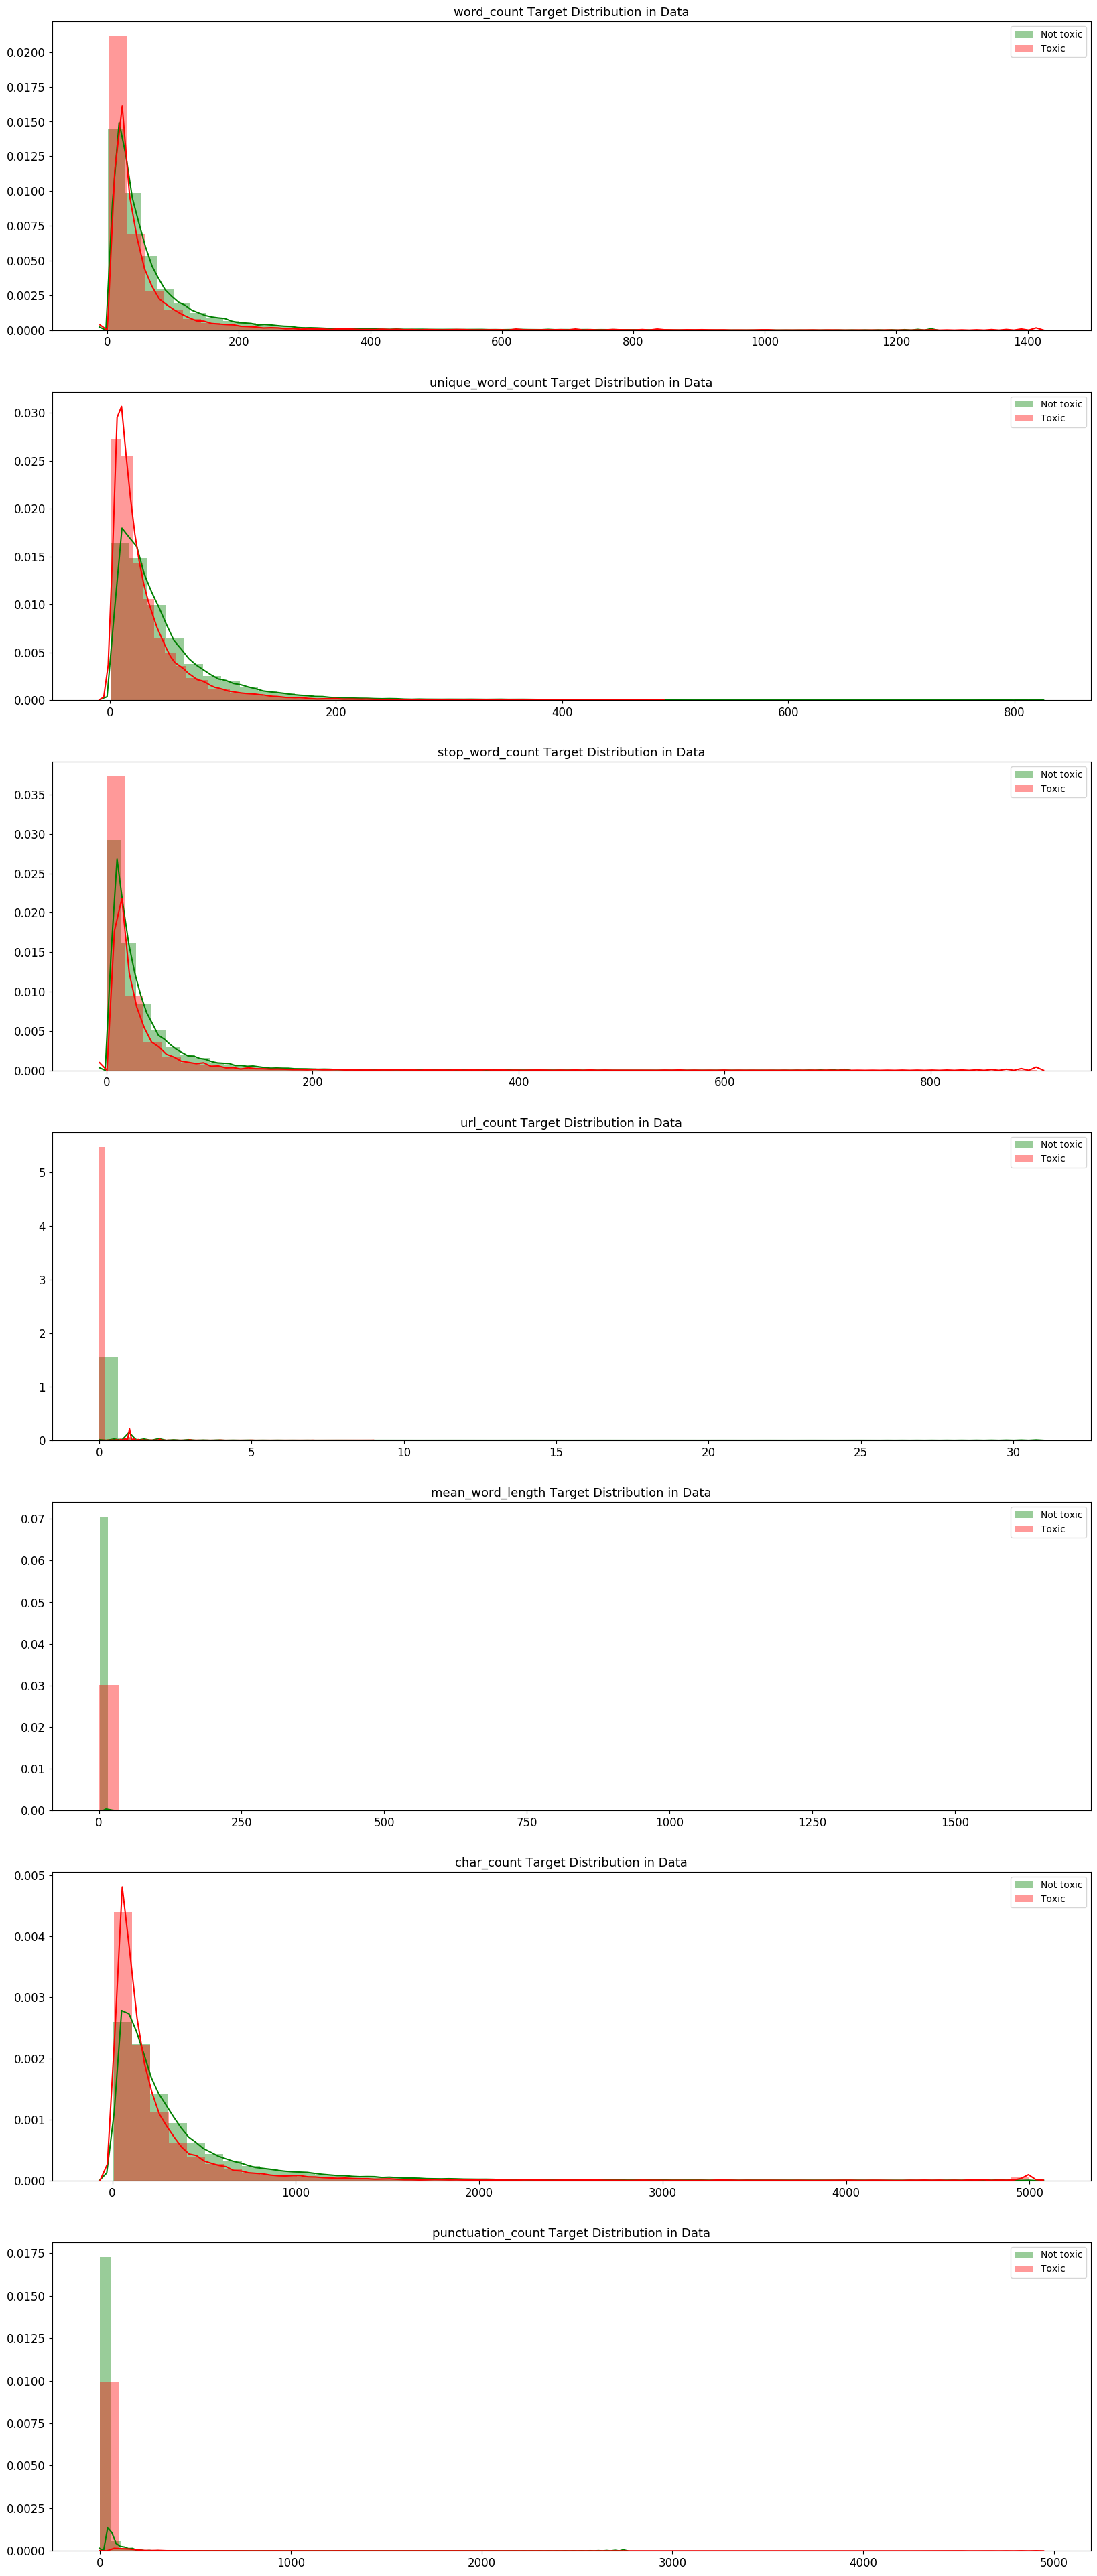

In [11]:
meta_features = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count']
TOXIC_COMMENTS = data['toxic'] == 1

fig, axes = plt.subplots(ncols=1, nrows=len(meta_features), figsize=(20, 50), dpi=100)

for i, feature in enumerate(meta_features):
    sns.distplot(data.loc[~TOXIC_COMMENTS][feature], label='Not toxic', ax=axes[i], color='green')
    sns.distplot(data.loc[TOXIC_COMMENTS][feature], label='Toxic', ax=axes[i], color='red')

    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()

    axes[i].set_title(f'{feature} Target Distribution in Data', fontsize=13)

plt.show()

Из графиков видно что токсичные комментарии чаще оказываются короче и при этом содержат больше уникальных слов

## Очистка
Очистим тексты с помощию регулярных выражений:
1. Приведем все к нижнему регистру 
2. Удалим спец символы \n \r
3. Выберем только слова

In [12]:
def clean(text):
    
    text = text.lower()    
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    
    return text

In [13]:
data['text_clean'] = data['text'].apply(clean)
data[['text', 'text_clean']].sample(5, random_state=SEED)

,text,text_clean
45925,Photograph \n\nThere's nothing wrong with your...,photograph theres nothing wrong with your ne...
1242,"""\nre this, it looks like Ultrabias/DY71. ^_^ """,re this it looks like ultrabiasdy
105698,No. There is no imagery or significance easil...,no there is no imagery or significance easily...
125591,The title of this article shouldn't have a quo...,the title of this article shouldnt have a quot...
13235,This IP address has also vandalized Lancaster ...,this ip address has also vandalized lancaster ...


## Лемматизация
Лемматизируем текст с помощью spacy

In [14]:
nlp = en_core_web_sm.load()

In [15]:
def lemmatize(text):
    temp = []
    for token in nlp(text):
        if token.is_stop == False:
            temp.append(token.lemma_)
    return " ".join(temp)

In [16]:
tqdm.pandas()
data['text_lemma'] = data['text_clean'].progress_apply(lemmatize)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 159571/159571 [44:57<00:00, 59.16it/s] 


Сохраним полученный датасет что бы не выполнять операции заново

In [17]:
dump(data, DATA_PREPARED_FILE)

['toxic_comments_ready']

In [18]:
data[['text', 'text_lemma']].sample(5, random_state=SEED)

,text,text_lemma
45925,Photograph \n\nThere's nothing wrong with your...,photograph s wrong new picture look lovely ...
1242,"""\nre this, it looks like Ultrabias/DY71. ^_^ """,look like ultrabiasdy
105698,No. There is no imagery or significance easil...,imagery significance easily discernible act ...
125591,The title of this article shouldn't have a quo...,title article not quote
13235,This IP address has also vandalized Lancaster ...,ip address vandalize lancaster bible college


# 2. Обучение

## Подготовка

Разделим данные на тестовую, валидационную и обучающую выборки

In [19]:
data = load(DATA_PREPARED_FILE)
data.shape

(159571, 11)

In [20]:
X = data.drop(columns=['toxic'])
y = data['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    random_state=SEED)
X_train_valid, X_valid, y_train_valid, y_valid = train_test_split(X_train, y_train,
                                                                 shuffle=True,
                                                                 test_size=0.2,
                                                                 random_state=SEED)
print('Train_valid shapes:')
print(X_train_valid.shape, y_train_valid.shape)
print('Valid shapes:')
print(X_valid.shape, y_valid.shape)
print('Test shapes:')
print(X_test.shape, y_test.shape)

Train_valid shapes:
(102124, 10) (102124,)
Valid shapes:
(25532, 10) (25532,)
Test shapes:
(31915, 10) (31915,)


## Tf-idf и логистическая регрессия

1. Составим пайплайн: Tf-idf -> Classifier
1. В качестве Classifier попробуем LogisticRegression, так как остальные не отрабатывают за приемлемое время на таком количестве признаков
1. Проверим результат на валидационной выборке для очищенного текста и лемматизированного

In [21]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', LogisticRegression(random_state=SEED, solver='liblinear')) #lbfgs
    ])

In [22]:
for col in ['text_clean', 'text_lemma']:
    pipe.fit(X_train_valid[col], y_train_valid);
    y_valid_pred = pipe.predict(X_valid[col])
    f1 = f1_score(y_valid, y_valid_pred)
    print('F1 for', col, 'is', f1)

F1 for text_clean is 0.7179487179487178
F1 for text_lemma is 0.7262366081604741


Как мы видим лемматизированный текст дает метрику лучше чем просто очищенный, посмострим на самые важные слова

In [23]:
eli5.show_weights(pipe, top=50)

Weight?,Feature
+17.157,fuck
+12.205,idiot
+12.103,shit
+11.814,fucking
+10.609,stupid
+10.039,suck
+10.002,ass
+9.280,asshole
+8.857,bullshit
+8.834,bitch


Попробуем добавить метапризнаки по смотрим на скор на валидаци

In [24]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
X_train_valid_left = vectorizer.fit_transform(X_train_valid['text_lemma'])
X_valid_left = vectorizer.transform(X_valid['text_lemma'])

scaler = StandardScaler()
X_train_valid_right = scaler.fit_transform(X_train_valid[meta_features])
X_valid_right = scaler.transform(X_valid[meta_features])

X_train_valid_vec = hstack((X_train_valid_left, X_train_valid_right))
X_valid_vec = hstack((X_valid_left, X_valid_right))

In [25]:
logit = LogisticRegression(random_state=SEED, solver='liblinear', max_iter=500)

logit.fit(X_train_valid_vec, y_train_valid);
y_valid_pred = logit.predict(X_valid_vec)
f1_score(y_valid, y_valid_pred)

0.7288444040036396

Метапризнаки чуть-чуть улушают метрику.

Далее попробуем улучшить результат настраивая гиперпараметр поиском по сетке.

In [26]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', LogisticRegression(random_state=SEED, solver='liblinear', max_iter=500)) #lbfgs
    ])

params = [
        {
            'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
            'model': [LogisticRegression(random_state=SEED, solver='liblinear')],
            'model__C': [1, 10, 50, 100, 200]
        }
]

In [27]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=cv, verbose=False)

In [28]:
%%time
grid.fit(X_train_valid['text_lemma'], y_train_valid)
dump(grid, GRID_FILE);

CPU times: user 16min 57s, sys: 7min 18s, total: 24min 15s
Wall time: 24min 29s


['grid_nlp']

In [29]:
grid = load(GRID_FILE)
grid.best_params_, grid.best_score_

({'model': LogisticRegression(C=200, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=21, solver='liblinear', tol=0.0001, verbose=0,
                     warm_start=False),
  'model__C': 200,
  'vectorizer__ngram_range': (1, 2)},
 0.7683816862740935)

In [30]:
model = grid.best_estimator_

model.fit(X_train_valid['text_clean'], y_train_valid)

y_valid_pred = model.predict(X_valid['text_clean'])

f1_score(y_valid, y_valid_pred)

0.7730422002939324

Подбор гиперпараметров сильно улучшил метрику.

Попробуем другие модели.

## CatBoost

В catboost с версии 0.20 появился модуль работы с текстами, но он работает только на GPU.

Поэтому эту часть сделал в Colab

https://colab.research.google.com/drive/13U86vjawzL3Dpt9cobw78-dHq_hedj3D

Есть права на редактирование

## Bert

Так как в практикуме bert нормально не работает, то я использовал его так же в colab

## Блендинг катбуста и логистической регрессии

Попробуем смешать катбуст и логистическую регрессию в разных пропорциях и посмотрим на скор.

Идея в том что эти модели имеют разную природу и на разных семплах дают разные предсказания.

Сделаем предсказания вероятностей для логистичекой регресси, для катбуста загрузим предсказания с колаб

In [31]:
logit_valid_predict = model.predict_proba(X_valid['text_clean'])[:, 1]

ctb_valid_predict = load('ctb_predict_valid')[:, 1]

In [32]:
weights = np.linspace(0.1, 0.9, 9)
best_w = 0
max_f1 = 0

for w in weights:
    
    final_pred = w*logit_valid_predict + (1-w)*ctb_valid_predict
    f1_final = f1_score(y_valid, np.round(final_pred))    
    print('{:.1f} logit + {:.1f} catboost = {}'.format(w, 1-w, f1_final))
    
    if f1_final > max_f1:
        best_w = w
        max_f1 = f1_final

0.1 logit + 0.9 catboost = 0.775144138372838
0.2 logit + 0.8 catboost = 0.7770891216071809
0.3 logit + 0.7 catboost = 0.779443254817987
0.4 logit + 0.6 catboost = 0.7848426461143224
0.5 logit + 0.5 catboost = 0.7824973319103521
0.6 logit + 0.4 catboost = 0.7804255319148937
0.7 logit + 0.3 catboost = 0.7786485914001271
0.8 logit + 0.2 catboost = 0.7761824324324325
0.9 logit + 0.1 catboost = 0.7737994945240101


Лучшее значение метрики получается при смешивании в пропрциях 0.40 logit + 0.60 catboost
Эту связку мы и будем использовать для теста.

# 3. Выводы

1. В колабе обучим catboost на всей трейн выборке и загрузим сюда.
1. Обучим логистическую регрессию
1. Сделаем предсказания и смешаем
1. Посмотрим метрику на тесте

In [33]:
ctb_test = load('ctb_test')[:, 1]

In [ ]:
model.fit(X_train['text_clean'], y_train)

logit_test = model.predict_proba(X_test['text_clean'])[:, 1]

In [ ]:
y_test_pred = np.round(best_w*logit_test + (1-best_w)*ctb_test)
f1_score(y_test, y_test_pred)

Получили метрику 0.7884

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны